# CAPM Calculations with Exponential Weights #

### CAPM Model using Weighted Linear Regression Model ###

In [1]:
# Import Libraries

# Data Management
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from data_downloader import get_market_data

In [2]:
# Weights
def wexp(N, half_life):
    c = np.log(0.5) / half_life
    n = np.array(range(N))
    w = np.exp(c * n)
    return np.flip(w / np.sum(w))

# Create the CAPM Function
def capm_regression(
    excess_stock: pd.Series,
    excess_benchmark: pd.Series,
    window: int = 252,
    WLS: bool = False,
):
    
    X = excess_benchmark
    y = excess_stock
    
    if WLS:
        # Create weights with exponential decay
        weights = window * wexp(window, window/2)
        
        # Fit WLS regression
        model = sm.WLS(y, sm.add_constant(X), weights=weights, missing='drop').fit()
    
    else:
        # Fit OLS regression
        model = sm.OLS(y, sm.add_constant(X), missing='drop').fit()
    
    return model
    
    
def rolling_capm_regression(
    stock_returns: pd.Series,
    benchmark_returns: pd.Series,
    daily_rfr: pd.Series,
    window: int = 252,
    WLS: bool = False,
):

    #Align Data
    df = pd.concat([stock_returns, benchmark_returns, daily_rfr], axis=1)
    df = df.dropna()
    df.columns = ['stock_returns', 'benchmark_returns', 'daily_returns']

    # Compute Excess Returns
    excess_stock = df['stock_returns'] - df['daily_returns']
    excess_benchmark = df['benchmark_returns'] - df['daily_returns']

    # Lists
    alphas, betas, sigma = [], [], []
    p_values_alpha, p_values_beta = [], []
    r_squared = []
    dates = []

    for t in range(window, len(excess_stock)):
        # The variables
        X = excess_benchmark.iloc[t-window:t]
        y = excess_stock.iloc[t-window:t]

        # Create the Model
        model = capm_regression(y, X, window=window, WLS=WLS)

        # Avoid KeyError by checking if params exist
        params = model.params
        pvalues = model.pvalues
        r2 = model.rsquared
        hsigma = (model.resid).std()

        # Append values
        alphas.append(params.iloc[0])
        betas.append(params.iloc[1])
        sigma.append(hsigma)
        p_values_alpha.append(pvalues.iloc[0])
        p_values_beta.append(pvalues.iloc[1])
        r_squared.append(r2)
        dates.append(excess_stock.index[t - 1])  # Last date to calculate betas
            
    parameters = pd.DataFrame({
        'alpha': alphas,
        'beta': betas,
        'sigma': sigma,
        'p_value_alpha': p_values_alpha,
        'p_value_beta': p_values_beta,
        'r_squared': r_squared,
    }, index=pd.Index(dates, name="date"))
    
    return parameters

In [3]:
# Get the important data for the Risk-Free Rate
rfr = pd.read_csv(r"..\additional_data\rfr.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index)
rfr.dropna(inplace = True)

rfr

,risk_free_rate
Date,
2015-01-02,0.000083
2015-01-05,0.000080
2015-01-06,0.000077
2015-01-07,0.000077
2015-01-08,0.000080
...,...
2025-06-10,0.000174
2025-06-11,0.000171
2025-06-12,0.000169


In [4]:
# Benchmark Data
data_sp500 = pd.read_csv(r'..\additional_data\sp500.csv')
data_sp500.set_index('Date', inplace=True)
data_sp500.index = pd.to_datetime(data_sp500.index)

data_sp500

,sp_500
Date,
2015-01-05,-0.018447
2015-01-06,-0.008933
2015-01-07,0.011563
2015-01-08,0.017730
2015-01-09,-0.008439
...,...
2024-12-24,0.010982
2024-12-26,-0.000406
2024-12-27,-0.011117


In [5]:
# Stock Data
ticker = 'NVDA'

df_stock = get_market_data(
        ticker=ticker, 
        start_date='2015-01-01', 
        end_date='2025-01-01', 
        returns=True
    )

df_stock

[*********************100%***********************]  1 of 1 completed


Price,close,high,low,open,volume,returns
Date,,,,,,
2015-01-05,0.474906,0.484505,0.472747,0.483066,197952000,-0.017034
2015-01-06,0.460508,0.476106,0.460028,0.475626,197764000,-0.030788
2015-01-07,0.459308,0.467947,0.457868,0.463868,321808000,-0.002609
2015-01-08,0.476586,0.479466,0.464348,0.464588,283780000,0.036928
2015-01-09,0.478506,0.482106,0.471787,0.478266,209540000,0.004020
...,...,...,...,...,...,...
2024-12-24,140.197372,141.877094,138.627618,139.977407,105157000,0.003930
2024-12-26,139.907410,140.827275,137.707768,139.677451,116205600,-0.002070
2024-12-27,136.987869,138.997554,134.688253,138.527629,170582600,-0.021088


In [7]:
# Calculate the Betas using WLS
betas_wls = rolling_capm_regression(
    df_stock['returns'],
    data_sp500['sp_500'],
    rfr['risk_free_rate'],
    WLS = True
)

betas_wls

,alpha,beta,sigma,p_value_alpha,p_value_beta,r_squared
date,,,,,,
2016-01-06,0.002497,1.182662,0.018135,0.033794,3.101150e-21,0.301350
2016-01-07,0.002397,1.206588,0.018155,0.041505,2.147062e-22,0.315990
2016-01-08,0.002360,1.211099,0.018114,0.044161,1.234389e-22,0.318987
2016-01-11,0.002385,1.214819,0.018076,0.041311,9.814360e-23,0.320225
2016-01-12,0.002396,1.213520,0.018060,0.039755,1.097836e-22,0.319620
...,...,...,...,...,...,...
2024-12-23,0.001325,2.547249,0.024952,0.395596,3.714770e-31,0.417307
2024-12-24,0.001149,2.522029,0.025011,0.462142,1.216192e-30,0.411783
2024-12-26,0.001149,2.524562,0.025003,0.460772,1.219584e-30,0.411770


In [8]:
# Calculate the Betas using OLS
betas_ols = rolling_capm_regression(
    df_stock['returns'],
    data_sp500['sp_500'],
    rfr['risk_free_rate'],
    WLS = False,
)

betas_ols

,alpha,beta,sigma,p_value_alpha,p_value_beta,r_squared
date,,,,,,
2016-01-06,0.002006,1.184499,0.018135,0.080919,1.441668e-20,0.292788
2016-01-07,0.001943,1.200203,0.018155,0.091268,4.092087e-21,0.299813
2016-01-08,0.001988,1.196970,0.018114,0.083420,3.986490e-21,0.299958
2016-01-11,0.002058,1.205765,0.018076,0.072560,2.412605e-21,0.302740
2016-01-12,0.002023,1.197498,0.018059,0.077316,5.649813e-21,0.298020
...,...,...,...,...,...,...
2024-12-23,0.002054,2.669811,0.024933,0.194827,1.858305e-31,0.420509
2024-12-24,0.001926,2.659689,0.024987,0.225600,5.635922e-31,0.415371
2024-12-26,0.001953,2.666374,0.024978,0.218670,5.543526e-31,0.415448


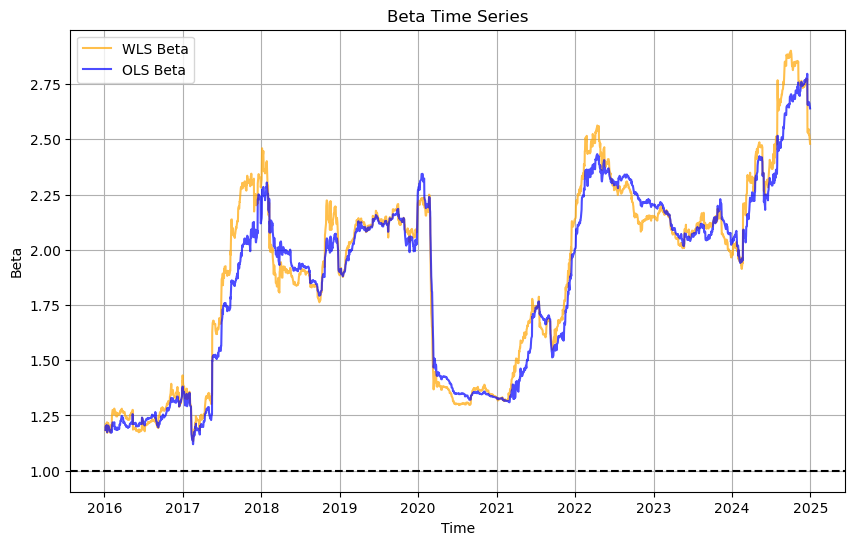

In [9]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['beta'], label='WLS Beta', color='orange', alpha=0.7)
plt.plot(betas_ols['beta'], label='OLS Beta', color='blue', alpha=0.7)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()

# Show
plt.grid()
plt.show()

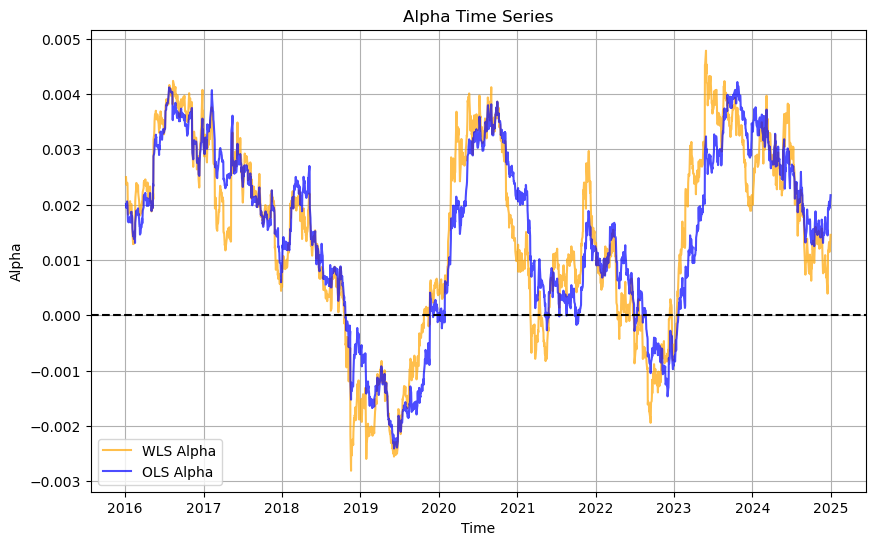

In [10]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['alpha'], label='WLS Alpha', color='orange', alpha=0.7)
plt.plot(betas_ols['alpha'], label='OLS Alpha', color='blue', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Alpha Time Series')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.legend()

# Show
plt.grid()
plt.show()

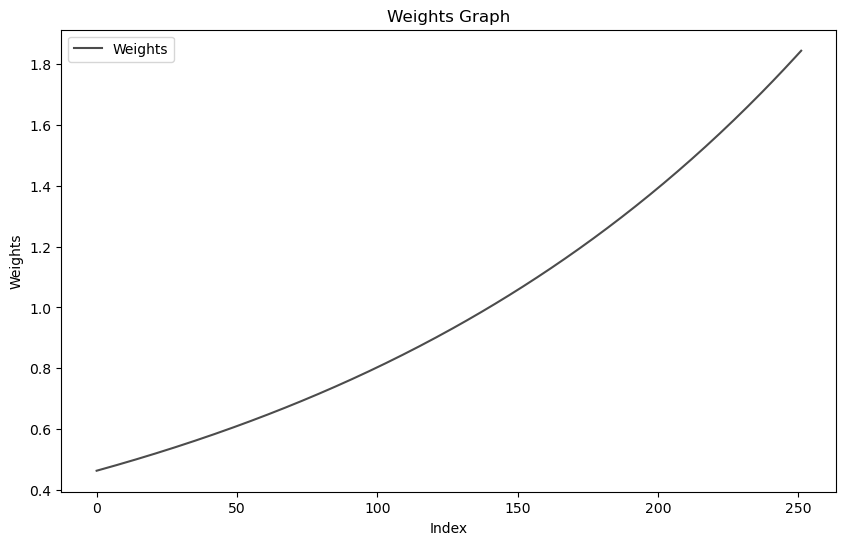

In [11]:
# Create Plot
weights = 252 * wexp(252, 126)

plt.figure(figsize=(10, 6))
plt.plot(weights, label='Weights', color='black', alpha=0.7)

# Config
plt.title('Weights Graph')
plt.xlabel('Index')
plt.ylabel('Weights')
plt.legend()

# Show
plt.show()

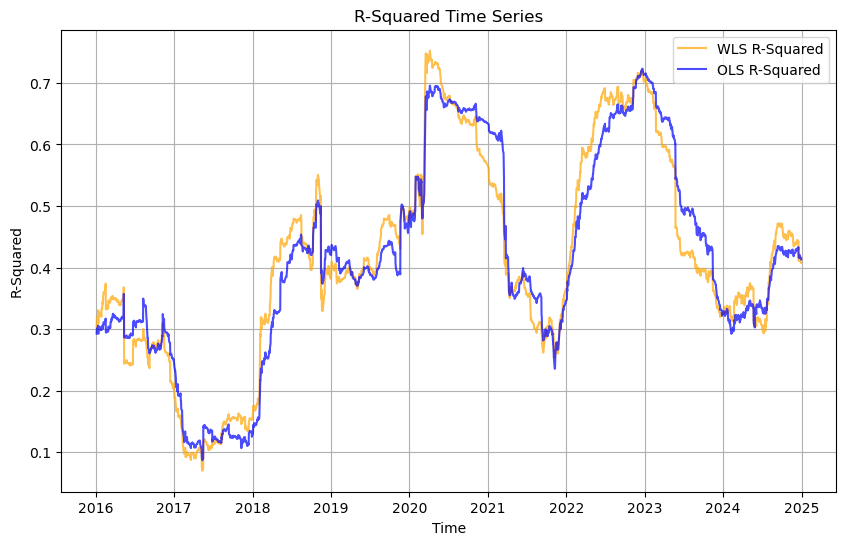

In [12]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['r_squared'], label='WLS R-Squared', color='orange', alpha=0.7)
plt.plot(betas_ols['r_squared'], label='OLS R-Squared', color='blue', alpha=0.7)

# Config
plt.title('R-Squared Time Series')
plt.xlabel('Time')
plt.ylabel('R-Squared')
plt.legend()

# Show
plt.grid()
plt.show()

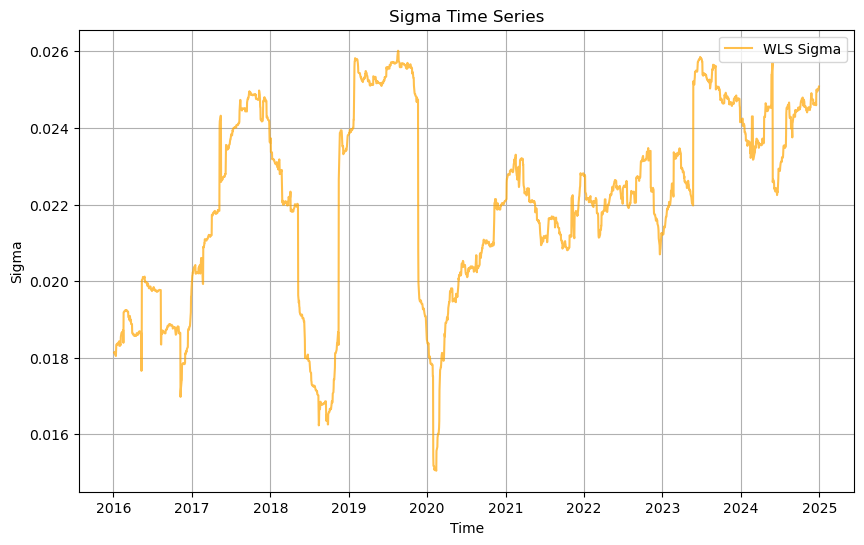

In [13]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['sigma'], label='WLS Sigma', color='orange', alpha=0.7)

# Config
plt.title('Sigma Time Series')
plt.xlabel('Time')
plt.ylabel('Sigma')
plt.legend()

# Show
plt.grid()
plt.show()

In [14]:
# Compute the Factor Contribution to Returns
def compute_factor_contributions(factor_returns, betas):
    # Multiply Elements
    contribution = (factor_returns * betas)

    return contribution

# Compute the Residual Returns
def compute_residual_returns(stock_excess_returns, factor_contributions):
    return stock_excess_returns - factor_contributions

In [16]:
# Create the Residual Returns DF

capm_returns_df = pd.DataFrame(index=betas_wls.index)

capm_returns_df['stock_excess_returns'] = df_stock['returns'] - rfr['risk_free_rate']
capm_returns_df['market_excess_returns'] = data_sp500['sp_500'] - rfr['risk_free_rate']
capm_returns_df['betas'] = betas_wls['beta']

capm_returns_df['factor_returns'] = compute_factor_contributions(
    capm_returns_df['market_excess_returns'], 
    capm_returns_df['betas']
)

capm_returns_df['residual_returns'] = compute_residual_returns(
    capm_returns_df['stock_excess_returns'],
    capm_returns_df['factor_returns']
)

capm_returns_df

,stock_excess_returns,market_excess_returns,betas,factor_returns,residual_returns
date,,,,,
2016-01-06,-0.042315,-0.013288,1.182662,-0.015715,-0.026600
2016-01-07,-0.040537,-0.024071,1.206588,-0.029043,-0.011493
2016-01-08,-0.021784,-0.010981,1.211099,-0.013299,-0.008485
2016-01-11,0.001601,0.000768,1.214819,0.000933,0.000668
2016-01-12,0.016623,0.007689,1.213520,0.009331,0.007291
...,...,...,...,...,...
2024-12-23,0.036054,0.007083,2.547249,0.018042,0.018013
2024-12-24,0.003752,0.010804,2.522029,0.027248,-0.023496
2024-12-26,-0.002248,-0.000583,2.524562,-0.001473,-0.000775


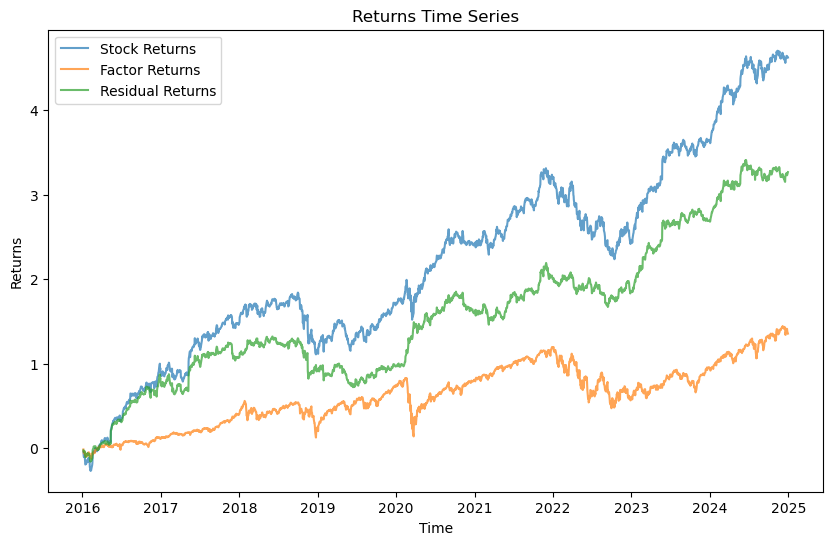

In [17]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(capm_returns_df['stock_excess_returns'].cumsum(), label='Stock Returns', alpha=0.7)
plt.plot(capm_returns_df['factor_returns'].cumsum(), label='Factor Returns', alpha=0.7)
plt.plot(capm_returns_df['residual_returns'].cumsum(), label='Residual Returns', alpha=0.7)

# Config
plt.title('Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.show()

### Variance Decomposition ###

Variance Decomposition

1) $ \mathrm{Var}(\mu_i) = \mathrm{Var}(\beta_0 + \beta_1\mu_M + u_i) $

Distributing the Variance Operator (assuming betas are constant):

2) $ \mathrm{Var}(\mu_i) = \mathrm{Var}(\beta_0) + \mathrm{Var}(\beta_1\mu_M ) + \mathrm{Var}(u_i)$
3) $ \sigma_i^2 = \beta_1^2\sigma_M^2 + \sigma_u^2 $

Recalling the alternative calculation of the beta coefficient (check the guide in the Module 4 Files)

4) $ \sigma_i^2 = \left( \rho_{i,M}\frac{\sigma_i}{\sigma_M} \right)^2 \sigma_M^2 + \sigma_u^2 $
5) $ \sigma_i^2 = \rho_{i,M}^2\sigma_i^2 + \sigma_u^2 $

Finally, solving for the variance of the errors:

6) $ \left( 1 - \rho_{i,M}^2 \right) \sigma_i^2 = \sigma_u^2 $

In [22]:
# First Calculate the Variance of the Stock
stock_variance = df_stock['returns'].var()

stock_variance

0.0009227171637948115

In [25]:
# Now calculate the Variance of the Market
market_variance = data_sp500['sp_500'].var()

market_variance

0.00012700667546369418

In [49]:
# And the Residuals Variance
stocks_market_corr = df_stock['returns'].corr(data_sp500['sp_500'])

resid_variance = (1 - stocks_market_corr*stocks_market_corr) * stock_variance

resid_variance

0.0005404976906233046

In [50]:
beta_model = capm_regression(
    df_stock['returns'],
    data_sp500['sp_500'],
    rfr['risk_free_rate'],
    WLS = False,
)

print(beta_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     1777.
Date:                Tue, 17 Jun 2025   Prob (F-statistic):          3.46e-294
Time:                        19:09:55   Log-Likelihood:                 5892.1
No. Observations:                2515   AIC:                        -1.178e+04
Df Residuals:                    2513   BIC:                        -1.177e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.000      3.261      0.0

In [56]:
# Extract the beta
beta = beta_model.params.iloc[1]

beta

1.7347749036798823

In [54]:
calculated_stock_variance = (beta*beta * market_variance) + resid_variance

calculated_stock_variance

0.0009227171637948104

In [55]:
# Note that the error is practically 0

stock_variance - calculated_stock_variance

1.0842021724855044e-18

In [63]:
# Now check how much of the variance is explained by the Market and how much by the errors

print(f'Residuals Variance Percentage: {(resid_variance / stock_variance).round(5) * 100}%')
print(f'Market Variance Percentage: {100 - ((resid_variance / stock_variance).round(5) * 100)}%')

Residuals Variance Percentage: 58.577%
Market Variance Percentage: 41.423%
